# Game of Drones on a Graph - Real Map Analysis (Tilburg)
This notebook contains a structured analysis of a **Stackelberg game** between a drone and a jammer, using a realistic graph extracted from OpenStreetMap (OSM) centered on **Tilburg, Netherlands**.

The notebook follows the implementation described in Section V.A of the associated research paper.

## Contents
1. Setup and Imports
2. Graph Processing and Map Construction
3. Game Elements (Routes, Threat, Payoff)
4. Stackelberg Game Logic
5. Results and Visualizations
6. Conclusions and Further Work

## Change Log:
20251107_0946 Initial upload on GitHub/nlcircle 
20251107_0949 First minor change and push

## 1. Setup and Imports

In [1]:
# import packages
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import numpy as np


from IPython.display import display


# graph constants
tilburg_bbox = [5.07, 51.554, 5.1, 51.566]   # Tilburg, area around MindLabs
epsilon = 20                                 # distance in meters for node integration

# route model
start_nodes = [[51.553608, 5.069024, 'Kromhout park'],
               [51.564203, 5.066040, 'RingbaanWest'],
               [51.565511, 5.100537, 'RingbaanOost'],
               [51.553628, 5.097518, 'Galjoenstraat'],
               [51.5669465636276, 5.080646900855821, 'Wilhelminapark'],
               [51.5631993195584, 5.107997457873059, 'Bossscheweg'],
               [51.55419099433148, 5.085804497908121, 'Willemsplein'],
               [51.56571632960617, 5.089517797871289, 'BesterdRing']]
target = [51.560931, 5.086468, 'Mindlabs']
nr_routes = 2500                              # k-factor for 'k_shortest_paths'

# threat model
jammer_nodes = [880]
probs = [0.4, 0.2, 0.05]


## 2. Graph Processing and Map Construction
This section defines the `OSMGraphProcessor` class for downloading, preprocessing, and displaying the graph.

In [2]:
# prepare functions to be called later
class OSMGraphProcessor:
    def __init__(self, bounding_box, epsilon=20):
        """
        Initialize the OSMGraphProcessor with a bounding box and epsilon (in meters).
        """
        self.north = bounding_box[3]
        self.south = bounding_box[1]
        self.east = bounding_box[2]
        self.west = bounding_box[0]
        self.epsilon = epsilon  # Distance threshold in meters for node consolidation
        self.graph = None

    def create_graph(self):
        """
        Create an initial graph from OSM data and preprocess it.
        """
        print("Downloading OSM graph...")
        bbox = [self.west, self.south, self.east, self.north]
        self.graph = ox.graph_from_bbox(bbox, network_type='walk')
        print("Graph downloaded.")

        # Convert to undirected
        print("Converting to undirected...")
        self.graph = self.graph.to_undirected()

        # Simplify the graph
        #print("Simplifying graph...")
        #self.graph = ox.simplify_graph(self.graph)

        # Consolidate nodes using DBSCAN
        self._consolidate_nodes()

        # Ensure all edges have a 'length' in meters
        print("Assigning edge lengths and initializing edge risk...")
        self._assign_edge_attributes()

    def _consolidate_nodes(self):
        """
        Use DBSCAN clustering to consolidate nodes closer than epsilon meters.
        """
        coords = np.array([[data['y'], data['x']] for node, data in self.graph.nodes(data=True)])
        eps_rad = self.epsilon / 6371000  # convert meters to radians for haversine
        clustering = DBSCAN(eps=eps_rad, min_samples=1, algorithm='ball_tree', metric='haversine')
        coords_rad = np.radians(coords)
        labels = clustering.fit_predict(coords_rad)

        label_to_node = {}
        mapping = {}
        for idx, (node, data) in enumerate(self.graph.nodes(data=True)):
            label = labels[idx]
            if label not in label_to_node:
                label_to_node[label] = node
            mapping[node] = label_to_node[label]

        # Relabel and consolidate
        print("Relabeling consolidated nodes...")
        self.graph = nx.relabel_nodes(self.graph, mapping, copy=False)
        self.graph = nx.convert_node_labels_to_integers(self.graph)  # optional

    def _assign_edge_attributes(self):
        """
        Assign 'length' and 'edge_risk' to all edges.
        """
        for u, v, key, data in self.graph.edges(keys=True, data=True):
            if 'length' not in data:
                # compute great-circle distance manually
                lat1, lon1 = self.graph.nodes[u]['y'], self.graph.nodes[u]['x']
                lat2, lon2 = self.graph.nodes[v]['y'], self.graph.nodes[v]['x']
                data['length'] = ox.distance.great_circle_vec(lat1, lon1, lat2, lon2)
            data['edge_risk'] = 0.0

    def plot_graph(self):
        """
        Plot the graph with geographic projection.
        """
        print("Plotting graph geographically...")
        fig, ax = ox.plot_graph(self.graph, figsize=(14,10),
                                node_size=10, node_color='maroon', 
                                edge_color='gray', bgcolor='k')

    def plot_stats(self):
        """
        Plot histogram of edge lengths and basic graph statistics.
        """
        lengths = [data['length'] for u, v, data in self.graph.edges(data=True)]
        plt.figure(figsize=(8,6))
        plt.hist(lengths, bins=50, color='blue', alpha=0.7)
        plt.title('Edge Length Distribution')
        plt.xlabel('Length (meters)')
        plt.ylabel('Count')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("Graph stats:")
        print(f"Number of nodes: {self.graph.number_of_nodes()}")
        print(f"Number of edges: {self.graph.number_of_edges()}")
        print(f"Average degree: {sum(dict(self.graph.degree()).values()) / self.graph.number_of_nodes():.2f}")
        print(f"Average edge length: {np.mean(lengths):.2f} meters")

    def get_graph(self):
        """
        Return the final processed graph.
        """
        return self.graph


class GoDGraph():

    def __init__(self, bbox, epsilon):
        G_intake = OSMGraphProcessor(bbox, epsilon)
        G_intake.create_graph()
        #G_intake.plot_graph()
       
        # now extract the actual graph from G_intake and read in as 'G':
        self.G = G_intake.get_graph()

## 3. Game Elements
Here we define the core components of the game model:
- `RoutesModel`: generates K shortest paths
- `ThreatModel`: sets jammer nodes and affects edge risks
- `PayoffMatrix`: evaluates the trade-offs between path length and threat exposure.
Each is encapsulated into a class.

In [3]:
class routes_model():
    """
    Class to hold and handle route objects. Receives a graph G, start nodes, 
    target node and number of shortest paths to calculate.
    Stores:
        - self.routes: route nodes and route-wide stats (length, risk)
        - self.edge_data: edge-level info per route
    """

    def __init__(self, G, start_nodes, target_node, nr_of_routes):
        self.graph = G
        self.start_nodes = start_nodes
        self.target_node = target_node
        self.nr_routes = nr_of_routes

        # Get routes and edge data
        self.get_new_routes()
        self.get_edge_data()
        self._get_routes_length()

        print("routes_model instantiated ...")

    def get_new_routes(self):
        """
        Find k-shortest routes from each start node to the target.
        """
        self.routes = dict()

        for start_index, start in enumerate(self.start_nodes):
            k_routes = list(ox.k_shortest_paths(self.graph,
                                                start, self.target_node,
                                                self.nr_routes,
                                                weight='length'))

            for route_index, route in enumerate(k_routes):
                route_name = f"Start{start_index}-Route{route_index}"
                self.routes[route_name] = {
                    'nodes': route, 'length': 0, 'risk': 0
                }

    def get_edge_data(self):
        """
        For each route, extract per-edge information: from, to, length, risk.
        Result is saved in self.edge_data.
        """
        self.edge_data = dict()

        for route_key, route_info in self.routes.items():
            node_path = route_info['nodes']
            route_edges = dict()

            for i, (u, v) in enumerate(zip(node_path[:-1], node_path[1:])):
                if self.graph.is_multigraph():
                    edge_dict = self.graph.get_edge_data(u, v)
                    length = edge_dict[0]['length']
                else:
                    length = np.nan

                route_edges[i] = {
                    'from': u,
                    'to': v,
                    'length': length,
                    'risk': 0 }

            self.edge_data[route_key] = route_edges

    def _get_routes_length(self):
        """Take all routes, calculate total length from route_model.edge_data and store
        in route_model.routes[key]['length']"""

        for route_key in self.routes:
            route_length = 0
            for edge in self.edge_data[route_key]:
                route_length += self.edge_data[route_key][edge]['length']
            self.routes[route_key]['length'] = route_length


    
    def _reset_route_model(self):
        """
        Reset the model: regenerate all routes and edge data.
        """
        self.get_new_routes()
        self.get_edge_data()
        print(f"Route | Reset of routes and edge_data, nr of new routes is {len(self.routes)}")

    def update_edges_with_jammer_risk(self, threat):
        """
        Update edge risks based on external threat object.
        """
        for route_key in self.edge_data:
            for edge_idx, edge in self.edge_data[route_key].items():
                u, v = edge['from'], edge['to']
                base_risk = edge['risk']

                if u in threat.threat_nodes and v in threat.threat_nodes:
                    delta = abs(threat.threat_nodes[u] - threat.threat_nodes[v])
                    match delta:
                        case 0:
                            risk_rank = threat.threat_nodes[u] + 1
                        case 1:
                            risk_rank = min(threat.threat_nodes[u], threat.threat_nodes[v])
                        case _:
                            risk_rank = 99

                    edge['risk'] = threat.probs[risk_rank] if risk_rank < 3 else base_risk

        print("Route | Edge data for new routes updated with threat data.")

## 3.2 - Class threat_model

Define the class for the jammer, capturing the threat model for this game.

In [4]:
class threat_model():

    def __init__(self, G, jnodes, probs):
        self.G = G                                # undirected graph from area
        
        self.jnodes = np.array(jnodes)            # array with jammer locations
        self.union_jammer_nodes = dict()          # create empty union bin for jammer nodes
        
        self.probs = [0.4, 0.2, 0.05]             # lethality probabilities per edge

        print(f"Threat | Model created, available nodes={self.jnodes}, probabilities={self.probs}")

    
    def set_threat_nodes(self, jammer_node):
        """
        Find set of affected nodes (threat_nodes) for a specific jammer_node
        """
        self.threat_nodes = nx.single_source_shortest_path_length(self.G, 
                                                                  jammer_node, 
                                                                  cutoff=len(self.probs))
        #print(f"Threat Model | Threat Nodes - {len(self.threat_nodes)} threat nodes found, jammer at {jammer_node}")


    def collect_jammer_nodes(self, route_model):
        """
        Use previously found routes from self.routes to build a union set of nodes where the jammer could
        be placed. For each node, its normalised presence in the route set is recorded.

        Note - a jammer doesn't have to be on the route to cause damage, nodes outside the route are not
        yet included in this union. How to find those ?
        """
        
        node_union = dict()
        nr_routes = len(route_model.routes)
        
        for route in route_model.routes:
            for index in np.arange(len(route)):
                print(route, index)
                if route[index] in node_union.keys():
                    node_union[route[index]] += 1
                else:
                    node_union[route[index]] = 1

        print(f"Threat | the union of the first {len(route_model.routes)} routes is {self.union_jammer_nodes}")




## 3.3 Class payoff_matrix

Contains two dictionaries, one for the value pairs (risk, length) and one for the lexicographic payoff 

\begin{equation}
\text{payoff} = - \gamma R(p,j) - L(p)
\end{equation}

with 

\begin{equation}
\gamma \geq \frac{\text{Max Length}}{\delta \text{Prob}}
\end{equation}
as per the paper.

In [5]:
class PayoffMatrix:
    def __init__(self, gamma=5000 / 0.01, length_scale=2000):
        self.value_matrix = {}   # {(route_index, jammer_node): {"length": ..., "risk": ...}}
        self.payoff_matrix = {}  # {(route_index, jammer_node): payoff}
        self.gamma = gamma
        self.normalisation = gamma * 1 + length_scale
        print("PayoffMatrix | initialized.")

    def compute(self, graph, route_model, jammer_nodes, threat_model):
        route_model.get_edge_data()  # Ensure edge_data is updated
        num_routes = len(route_model.edge_data)

        for r_idx in range(num_routes):
            print(r_idx)
            original_edges = route_model.edge_data[r_idx].copy()

            for j_node in jammer_nodes:
                updated_edges = self._update_risks(original_edges.copy(), j_node, threat_model)

                total_length = 0
                survival_prob = 1

                for edge in updated_edges.values():
                    total_length += edge["length"]
                    survival_prob *= (1 - edge["risk"])

                risk = 1 - survival_prob
                self.value_matrix[(r_idx, j_node)] = {"length": total_length, "risk": risk}

                # Convert to single payoff
                payoff = (-self.gamma * risk - total_length) / self.normalisation
                self.payoff_matrix[(r_idx, j_node)] = payoff

    def _update_risks(self, edge_dict, jammer_node, threat_model):
        threat_model.set_threat_nodes(jammer_node)

        for edge_key, edge_data in edge_dict.items():
            u, v = edge_data["from"], edge_data["to"]
            rank_u = threat_model.threat_nodes.get(u, -1)
            rank_v = threat_model.threat_nodes.get(v, -1)

            if rank_u >= 0 and rank_v >= 0:
                delta = abs(rank_u - rank_v)
                if delta == 0:
                    rank = rank_u
                elif delta == 1:
                    rank = min(rank_u, rank_v)
                else:
                    rank = 9999
                edge_data["risk"] = threat_model.probs[rank] if rank < len(threat_model.probs) else 0
            else:
                edge_data["risk"] = 0

        return edge_dict

    def save_to_txt(self, prefix="GoDonAGraph"):
        with open(f"{prefix}_value.txt", 'w') as vf:
            for (r, j), val in self.value_matrix.items():
                vf.write(f"Route {r}, jammer at {j} - dist={val['length']:.2f}, risk={val['risk']:.4f}\n")

        with open(f"{prefix}_payoff.txt", 'w') as pf:
            for (r, j), val in self.payoff_matrix.items():
                pf.write(f"Route {r}, jammer at {j} - payoff={val:.3f}\n")

        print(f"PayoffMatrix | files '{prefix}_value.txt' and '{prefix}_payoff.txt' written.")


# 4 - Game of Drone on a Graph

This section handles the overall game definition based on the previous classes and contains a separate section on the analysis.

## 4.1 Class GameOfDronesOnAGraph

This is the main game class, which includes the threat_model, the route_model and the graph. From this class, the various types of analysis are handled.

In [6]:
class GameOfDronesOnAGraph():

    def __init__(self, start_set, target_coord, nr_routes,
                 bbox, epsilon,
                 jammer_nodes, probs):
        """GoD environment, defining entire game and support classes."""
        # set generic parameters for the game
        self.V = dict()                # value (length,risk) for each route/jammer node pair

        # create and plot the graph first:
        self.bbox = bbox   
        self.G = GoDGraph(self.bbox, epsilon).G
        self.fig, self.ax = ox.plot_graph(self.G, figsize=(12, 10), node_size=5, show=False, close=False)
        if self.G:
            print(f"GameOfDronesOnAGraph - Graph G generated {self.G}")

        # set parameters for obtaining 'nr_of_routes' routes
        start_nodes = self._get_start_nodes_from_coordinates(start_set)
        target_node = ox.distance.nearest_nodes(self.G, target_coord[1], target_coord[0])
        print(f"GameOfDronesOnAGraph - Start: {start_nodes}, Target: {target_node}")

        # create routes and plot these in the existing graph:
        self.R = routes_model(self.G, start_nodes, target_node, nr_routes)
        print(f"GameOfDronesOnAGraph - Routes generated {self.R}")
        self._plot_routes_from_routemodel_on_graph()

        # set jammer nodes:
        self.T = threat_model(self.G, jammer_nodes, probs)
        print(f"GameOfDronesOnAGraph - Threat model loaded {self.T}")

        # create payoff matrix
        self.PM = PayoffMatrix()
        print(f"GameOfDronesOnAGraph - PayOff matrix {self.PM}")


        # report results to user
        print(f"GameOfDrones | Start from node {self.R.start_nodes} to target on node {self.R.target_node}")


    def _get_start_nodes_from_coordinates(self, start_set):
        return([ox.distance.nearest_nodes(self.G, start[1], start[0]) for start in start_set])


  
    def plot_nodes(self, coordinates, color):
        """ Find nearest node to a given (lat, lon) and plot it on the graph. """
    
        cmap = mpl.colormaps.get_cmap('plasma')
        nodes = [ox.distance.nearest_nodes(self.G, c[1], c[0], return_dist=False) for c in coordinates ]
        for index, n in enumerate(nodes):
            self.ax.scatter(self.G.nodes[n]['x'], 
                            self.G.nodes[n]['y'],
                            color=color,
                            s=50,
                            label=coordinates[index][2],
                            zorder=5)

        self.ax.legend()
        display(self.fig)
        plt.savefig('GoD Tilburg area incl start nodes and target node.png')
 
    def _plot_routes_from_routemodel_on_graph(self):
        for start in self.R.routes:
            self.plot_route_on_graph(self.G, self.R.routes[start]['nodes'])
        display(self.fig)

    
    def plot_route_on_graph(self, G, route):
        """Plot a specified route (list of node IDs) on the shared ax."""
        # Extract coordinates
        x = [G.nodes[node]['x'] for node in route]
        y = [G.nodes[node]['y'] for node in route]
        
        # Plot the route on the existing axis
        self.ax.plot(x, y, color='yellow', linewidth=3, zorder=4)
    
        # Optionally highlight start and end
        self.ax.scatter(x[0], y[0], color='green', s=30, zorder=5)  # start node
        self.ax.scatter(x[-1], y[-1], color='red', s=30, zorder=5)  # end node
    


## Run the game

The game is initiated with a set of start nodes, for instance the four corners of the bounding box. Once the GT class is instantiated, the four start nodes and the target node is plotted.

Graph downloaded.
Converting to undirected...
Relabeling consolidated nodes...
Assigning edge lengths and initializing edge risk...
GameOfDronesOnAGraph - Graph G generated MultiGraph with 719 nodes and 2007 edges
GameOfDronesOnAGraph - Start: [402, 235, 287, 622, 358, 648, 1, 288], Target: 516
routes_model instantiated ...
GameOfDronesOnAGraph - Routes generated <__main__.routes_model object at 0x7b1701a33310>


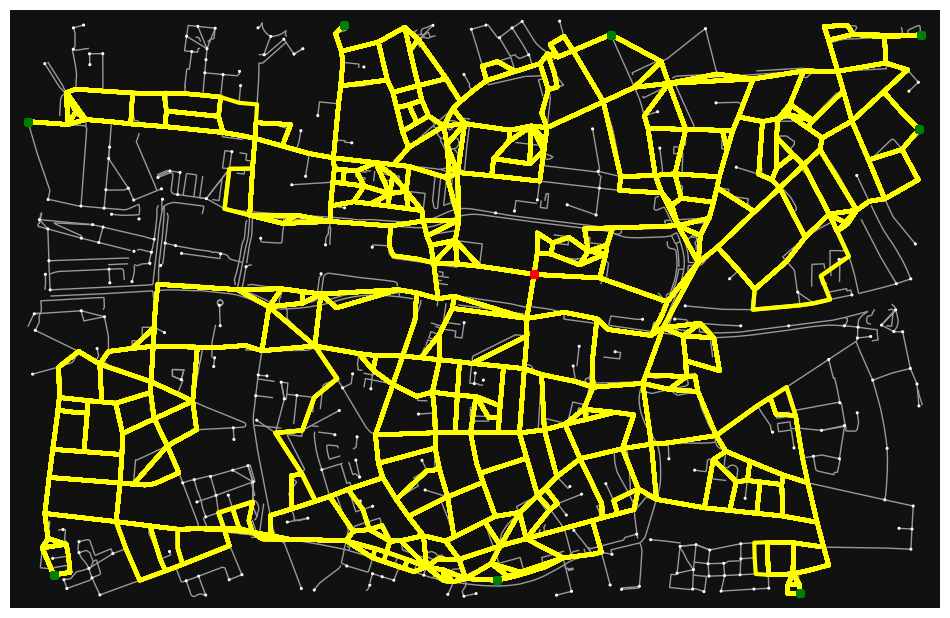

Threat | Model created, available nodes=[880], probabilities=[0.4, 0.2, 0.05]
GameOfDronesOnAGraph - Threat model loaded <__main__.threat_model object at 0x7b16c5e83710>
PayoffMatrix | initialized.
GameOfDronesOnAGraph - PayOff matrix <__main__.PayoffMatrix object at 0x7b16c68405d0>
GameOfDrones | Start from node [402, 235, 287, 622, 358, 648, 1, 288] to target on node 516


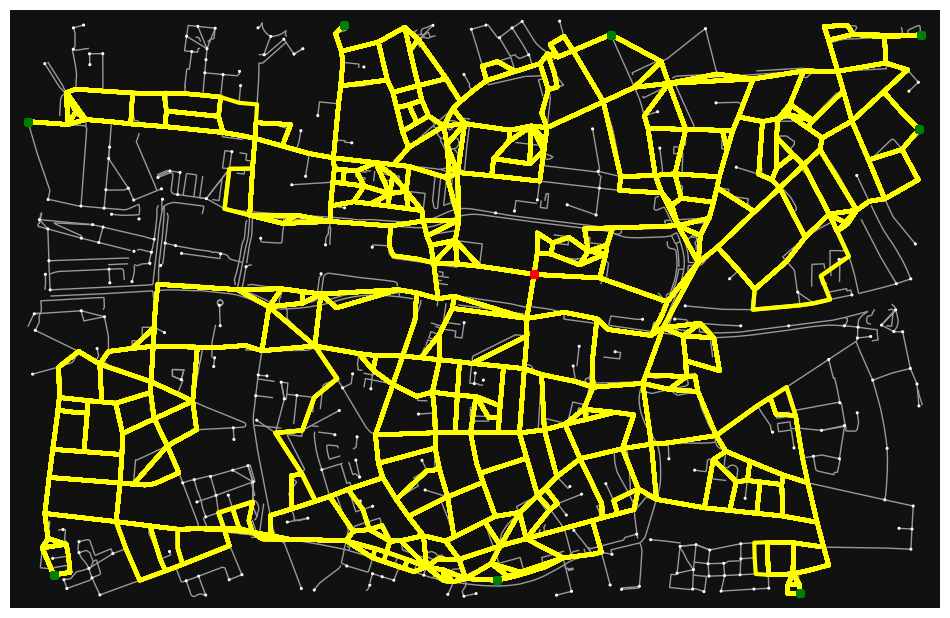

In [7]:
GT = GameOfDronesOnAGraph(start_nodes, target, nr_routes, tilburg_bbox, epsilon, jammer_nodes, probs);


In [20]:
GT.PM.__dict__

{'value_matrix': {},
 'payoff_matrix': {},
 'gamma': 500000.0,
 'normalisation': 502000.0}

## Generate routes

Use the defined start points to generate a number 'k' of routes from each point to the target. Plot these in varying colors, depending on their origin.

The routes are returned in a dictionary 'total_routes', which can be addressed as follows:

\begin{equation}
total_routes = \text{{'start1': [[route1], [route2], ... [routek]], 'start2': [[route1], [route2], ... [routek]], ...}}
\end{equation}


## Heatmap for total_routes

With a sufficient number of routes generated, we produce a heat map of the graph, where the edges and nodes are displayed as function of the number of times they have been traversed.

The function below allows coloring of these edges and nodes as well, but the resulting heatmap quickly becomes incomprehensible. For now, stick to the width of the edges and the size of the nodes to display more frequent usage.

In [9]:
import matplotlib as mpl
from collections import Counter

def plot_node_edge_heatmap_scaled(G, R, figsize=(12, 10)):
    """
    Plots a heatmap on graph G with:
    - node color & size scaled by visitation frequency
    - edge color & width scaled by traversal frequency

    Parameters:
        G: NetworkX graph
        total_routes: dict[start_node] = list of paths (each path is a list of node IDs)
        figsize: size of figure
    """

    cmap = mpl.colormaps.get_cmap('jet')  #plasma, viridis, jet, gnuplot2

    # Step 1: Flatten all routes into node visits and edge traversals
    all_nodes = []
    all_edges = []

    route_keys = R.routes.keys()

    for route_key in route_keys:
        route = R.routes[route_key]['nodes']
        
        all_nodes.extend(route)

        for i in range(len(route) - 1):
            u, v = route[i], route[i + 1]
            if G.has_edge(u, v):
                all_edges.append((u, v))
            elif G.has_edge(v, u):
                all_edges.append((v, u))

    # Step 2: Count frequencies
    node_counts = Counter(all_nodes)
    edge_counts = Counter(all_edges)

    max_node_count = max(node_counts.values(), default=1)
    total_node_visits = sum(node_counts.values())
    
    max_edge_count = max(edge_counts.values(), default=1)
    total_edge_visits = sum(edge_counts.values())

    # Step 3: Prepare node attributes
    node_color = []
    node_size = []
    node_norm = []

    for node in G.nodes:
        count = node_counts.get(node, 0)
        norm = count / total_node_visits if total_node_visits > 0 else 0
        node_norm.append(norm)
        #node_color.append(count)
        node_color = 'black'
        node_size.append(5 + 3000 * norm)  # adjustable scaling

    # Step 4: Prepare edge attributes
    edge_color = []
    edge_width = []
    edge_norm = []

    for u, v in G.edges():
        count = edge_counts.get((u, v), edge_counts.get((v, u), 0))
        norm = count / total_edge_visits if total_edge_visits > 0 else 0
        edge_norm.append(norm)
        #edge_color.append(cmap(norm))             # RGBA color
        if norm>0:
            color='red'
        else:
            color='black'
        edge_color.append(color)
        edge_width.append(.5 + 250 * norm)        # linewidth range: [0.5, 5.0]

    # Step 5: Plot
    fig, ax = ox.plot_graph(
        G,
        node_color=node_color, node_size=node_size, node_zorder=2,
        edge_linewidth=edge_width, edge_color=edge_color,
        bgcolor='white',
        show=False, close=False,
        figsize=figsize
    )

    plt.show()

    return(node_counts, node_norm, edge_norm)

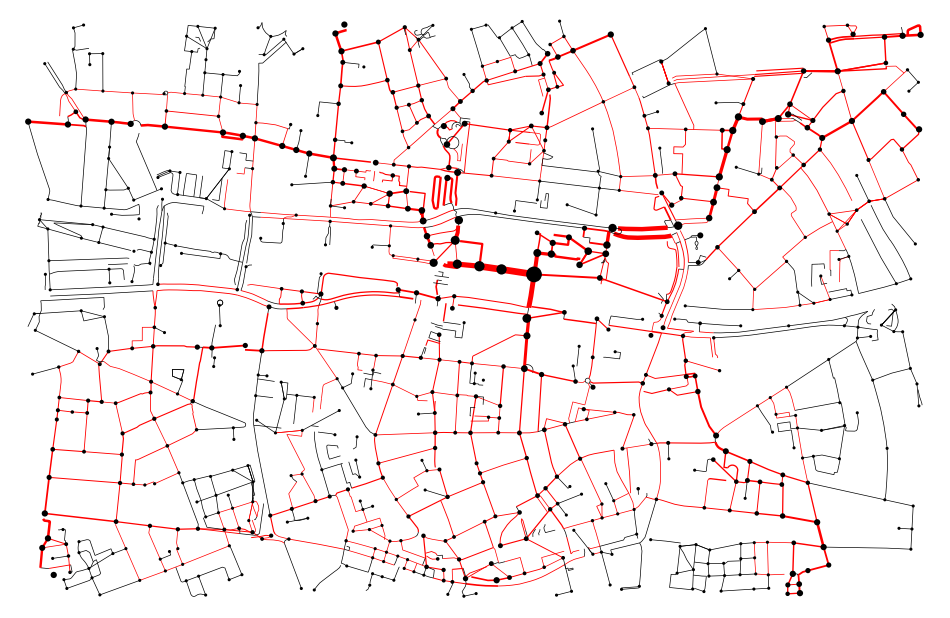

In [10]:
Cnodes, Nnode, Nedge = plot_node_edge_heatmap_scaled(GT.G, GT.R, figsize=(12, 10))

In [11]:
# analyse the MC routes to find average, longest and shortest route in the entire set;

tot_nodes = 0
shortest_route = 100
longest_route = 1
count = 0

for route in GT.R.routes:
    length = len(GT.R.routes[route]['nodes'])
    tot_nodes += length
    shortest_route =  min(shortest_route, length)
    longest_route = max(shortest_route, length)
    count+=1

avg_nodes_per_route = tot_nodes / count
print(f"The average nr of nodes per MC simulated route is {avg_nodes_per_route:2.1f}")
print(f"    longest route: {longest_route}, shortest_route: {shortest_route}")

The average nr of nodes per MC simulated route is 24.4
    longest route: 20, shortest_route: 11


## Node importance

As the heatmap is based on a histogram of node usage across 20.000 routes through this relative small section of a real map, it serves as an indicator of the likelikhood that a node is part of a randomly chosen route. 

For a realistic game-theoretic approach, we need to limit the number of jammer nodes. The heatmap or the estimated probability density function for the nodes can serve as first order approach towards reduction of the total set of graph nodes to the jammer node set.

In the next segment, we rank and filter the total set of node counts, based on their relative importance and a minimum value before a node can be included.

In [12]:
def plot_normalised_node_importance(counter):
    """Plots the values from a counter, until reaching a minimum value (min_count),
    with the node numbers on the x-axis
    """

    # Sort counter by value in descending order
    sorted_items = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    max_nodes = len(sorted_items)
  
    
    # Extract labels and values
    labels = [str(item[0]) for item in sorted_items[1:75]]  # Convert labels to strings if not already
    values = [item[1] for item in sorted_items[1:75]]
    max_value = len(GT.R.routes) 
    norm_values = [val/max_value for val in values]
    
    # Plot the data
    plt.figure(figsize=(10, 8))  # Optional: adjust figure size
    plt.bar(labels[:max_nodes], norm_values[:max_nodes], color='skyblue')

    # Add labels and title
    plt.xlabel('Node References')  # X-axis label
    plt.ylabel('Normalised Values')  # Y-axis label
    plt.title(f'Node importance ($N=75')  # Title
    
    # Rotate x-axis labels if needed (in case they are long)
    plt.xticks(rotation=90, ha='right')

    # Display the plot
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

    return(sorted_items)

#sorted_nodes = plot_normalised_node_importance(Cnodes)


# Entropy for sorted nodes



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class RouteEntropyAnalyzer:
    def __init__(self, G, routes):
        self.G = G
        self.routes = routes
        self.node_counts = None
        self.edge_counts = None
        self.node_entropy = None
        self.edge_entropy = None
        self.node_entropy_max = None
        self.edge_entropy_max = None
        self.node_freq = None
        self.edge_freq = None

    def compute_node_entropy(self):
        all_nodes = []
        for r in self.routes.values():
            all_nodes.extend(r["nodes"])

        self.node_counts = Counter(all_nodes)
        total = sum(self.node_counts.values())
        probs = np.array([count / total for count in self.node_counts.values()])
        self.node_entropy = -np.sum(probs * np.log2(probs))

        # Max entropy: log2 of number of unique nodes
        support_size = len(self.node_counts)
        self.node_entropy_max = np.log2(support_size)

        
        return self.node_entropy

    def compute_edge_entropy(self):
        all_edges = []
        for r in self.routes.values():
            nodes = r["nodes"]
            for i in range(len(nodes) - 1):
                u, v = nodes[i], nodes[i + 1]
                if self.G.has_edge(u, v):
                    all_edges.append((u, v))
                elif self.G.has_edge(v, u):
                    all_edges.append((v, u))

        self.edge_counts = Counter(all_edges)
        total = sum(self.edge_counts.values())
        probs = np.array([count / total for count in self.edge_counts.values()])
        self.edge_entropy = -np.sum(probs * np.log2(probs))

        # Max entropy: log2 of number of unique edges
        support_size = len(self.edge_counts)
        self.edge_entropy_max = np.log2(support_size)
        return self.edge_entropy


    def summarize_entropy(self):
        print("===== Entropy Summary =====")
        print(f"Node Entropy      H = {self.node_entropy:.4f} bits")
        print(f"Max Node Entropy  H_max = {self.node_entropy_max:.4f} bits")
        print(f"Relative Node Entropy = {100 * self.node_entropy / self.node_entropy_max:.2f}%")
        print()
        print(f"Edge Entropy      H = {self.edge_entropy:.4f} bits")
        print(f"Max Edge Entropy  H_max = {self.edge_entropy_max:.4f} bits")
        print(f"Relative Edge Entropy = {100 * self.edge_entropy / self.edge_entropy_max:.2f}%")
        print("============================")

    def plot_entropy_distributions(self, top_n=30):
        total_nodes = sum(self.node_counts.values())
        total_edges = sum(self.edge_counts.values())

        sorted_nodes = sorted(self.node_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        sorted_edges = sorted(self.edge_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

        fig, axs = plt.subplots(2, 1, figsize=(12, 10))

        axs[0].bar([str(k) for k, v in sorted_nodes], [v/total_nodes for k, v in sorted_nodes], color="steelblue")
        axs[0].set_title(f"Top Node Visit Frequencies (Total = {total_nodes})")
        axs[0].set_ylabel("Relative Frequency")
        axs[0].tick_params(axis='x', rotation=90)

        axs[1].bar([f"{u}-{v}" for (u, v), c in sorted_edges], [c/total_edges for (u, v), c in sorted_edges], color="orange")
        axs[1].set_title(f"Top Edge Traversal Frequencies (Total = {total_edges})")
        axs[1].set_ylabel("Relative Frequency")
        axs[1].tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()

    def get_jammer_candidates(self, top_k=10):
        """Returns the top-k most visited nodes as jammer node candidates"""
        sorted_nodes = sorted(self.node_counts.items(), key=lambda x: x[1], reverse=True)
        jammer_nodes = [node for node, count in sorted_nodes[:top_k]]
        return jammer_nodes


In [14]:
# run the RouteEntropyAnalyser, plot the entropy distributions and list the proposed jammer nodes.
analyzer = RouteEntropyAnalyzer(GT.G, GT.R.routes)
analyzer.compute_node_entropy()
analyzer.compute_edge_entropy()
analyzer.summarize_entropy()
#analyzer.plot_entropy_distributions()
jammer_nodes = analyzer.get_jammer_candidates(top_k=10)
print("Suggested jammer node set:", jammer_nodes)

===== Entropy Summary =====
Node Entropy      H = 7.9934 bits
Max Node Entropy  H_max = 8.8673 bits
Relative Node Entropy = 90.15%

Edge Entropy      H = 8.6574 bits
Max Edge Entropy  H_max = 9.8106 bits
Relative Edge Entropy = 88.25%
Suggested jammer node set: [516, 608, 515, 551, 607, 154, 179, 319, 320, 409]


## Entropy weighing

We end up with both node entropy and the entropy for edges. we use the node frequencies and edge frequencies to calculate a new 'score' for each node, based on the following formula (see paper for further explanation):

\begin{equation}
    S(v) = \alpha . P(v) + (1 - \alpha) . \sum_{u \in N(v)} P(uv)
\end{equation}

where $P(v$ is the node frequency, $N(v)$ is the neighborhood of node $v$ (so the set of adjacent nodes)) and $P(uv)$ the edge frequency for edge u-v.

$S(v)$ is the node specific value which determines the ranking of nodes prior to inclusion in the jammer node set (nodes with highest $n$ score values)

In [15]:
import pandas as pd

# Set alpha: weight of relative node importance
alpha = 0.5

# get relative node importance:
node_freq = analyzer.node_counts
total_node_freq = sum(node_freq.values())

rel_node_imp = {
    v: node_freq.get(v, 0) / total_node_freq
    for v in GT.G.nodes()
}


# Normalized edge usage
edge_freq = analyzer.edge_counts
total_edge_freq = sum(analyzer.edge_counts.values())

norm_edge_freq = {
    e: edge_freq.get(e, edge_freq.get((e[1], e[0]), 0)) / total_edge_freq
    for e in GT.G.edges()
}

# Score computation
score_data = []
for v in GT.G.nodes():
    rni = rel_node_imp.get(v, 0.0)
    neighbor_edges = list(GT.G.edges(v))
    edge_vals = [norm_edge_freq.get((u, w), norm_edge_freq.get((w, u), 0.0)) for u, w in neighbor_edges]
    nei = np.mean(edge_vals) if edge_vals else 0.0
    score = alpha * rni + (1 - alpha) * nei
    score_data.append((v, rni, nei, score))

# Create and sort the score table
df_scores = pd.DataFrame(score_data, columns=["Node", "RelNodeImportance", "MeanEdgeImportance", "Score"])
df_scores_sorted = df_scores.sort_values(by="Score", ascending=False).reset_index(drop=True)

# Display top 10 nodes
jammer_node_set = df_scores_sorted.head(10).to_string(index=False)


## Reduce Routes for payoff matrix

In previous sections, we have used a Monte Carlo approach to simulate a total of 20.000 routes from eight start positions to the target. These routes have been used to establish a priority over some nodes, which makes these elligible as jammer nodes (due to node importance considerations).

To avoid an explosion of the payoff matrix, we need to reduce the routes to a number of 'representative routes' to demonstrate the principle of a sequential game on a real map. The following section deals with this process of reduction, aiming to establish a realistic and representative route set for the sequential game and thus payoff matrix.

For our paper, we apply the Subgraph Strategy, where all routes are condensed to a subgraph arount the target T, under the assumption that regardless where the drone approaches from, any route will eventually converge to a smaller set of ingress routes when closer to the target. The next cell calculates the subgraph based on the 'reach' of the threat model (number of hops) and analyses the possible start nodes on the edges to define an entropy based ingress set.


In [16]:
import networkx as nx
from collections import defaultdict
import numpy as np
import heapq

class SubgraphGameOfDrones:
    def __init__(self, G_full, target_node, k_hops, node_importance_dict, jammer_nodes, alpha_thresh):
        self.G_full = G_full
        self.target = target_node
        self.k_hops = k_hops
        self.node_importance = node_importance_dict
        self.jammer_nodes = jammer_nodes
        self.alpha = alpha_thresh

        self.subgraph = None
        self.start_nodes = []
        self.routes = defaultdict(list)  # key: start node, value: list of paths
        self.route_value_matrix = []

    def create_subgraph(self):
        nodes_within_k = nx.single_source_shortest_path_length(self.G_full, self.target, cutoff=self.k_hops)
        self.subgraph = self.G_full.subgraph(nodes_within_k.keys()).copy()

    def select_viable_start_nodes(self):
        self.start_nodes = [n for n in self.subgraph.nodes if self.node_importance.get(n, 0) >= self.alpha 
                            and n != self.target 
                            if len(nx.shortest_path(self.subgraph, 
                                                    n, 
                                                    self.target, weight='length')) == 7 ]
        #print(f"Start nodes for alpha={self.alpha:2.4f} are {self.start_nodes}")
        

    def generate_k_shortest_routes(self, k_per_start_node=100):
        for s in self.start_nodes:
            paths = list(ox.k_shortest_paths(self.subgraph, 
                                             orig=s, dest=self.target, 
                                             k=k_per_start_node, 
                                             weight='length'))
            self.routes[s] = paths[:k_per_start_node]

                

    def _compute_risk(self, path, jammer_node, threat_model_obj):
        threat_model_obj.set_threat_nodes(jammer_node)
        affected_nodes = threat_model_obj.threat_nodes
        probs = threat_model_obj.probs

        prob_product = 1.0
        for u, v in zip(path[:-1], path[1:]):
            r1 = affected_nodes.get(u, None)
            r2 = affected_nodes.get(v, None)
            risk1 = probs[r1 - 1] if r1 and r1 <= len(probs) else 0.0
            risk2 = probs[r2 - 1] if r2 and r2 <= len(probs) else 0.0
            edge_risk = max(risk1, risk2)
            prob_product *= (1 - edge_risk)
        return 1 - prob_product


    def compute_route_value_matrix(self, risk_model):
        matrix = []
        for s, paths in self.routes.items():
            for path in paths:
                length = sum(self.G_full[u][v][0].get('length', 1.0) for u, v in zip(path[:-1], path[1:]))
                for jammer in self.jammer_nodes:
                    risk = self._compute_risk(path, jammer, risk_model)
                    matrix.append({
                        'start': s,
                        'path': path,
                        'jammer': jammer,
                        'risk': risk,
                        'length': length
                    })
        self.route_value_matrix = matrix


    def compute_lexicographic_payoff_matrix(self, gamma, battery_limit=None):
        """
        Constructs the lexicographic payoff matrix:
        For each route i and jammer j, stores the tuple (-risk, -length)
        """
        # Step 1: identify unique routes and jammer nodes
        unique_routes = []
        route_index_map = {}
        jammer_index_map = {}
        index = 0

        for entry in self.route_value_matrix:
            path_tuple = tuple(entry['path'])
            if path_tuple not in route_index_map:
                route_index_map[path_tuple] = len(unique_routes)
                unique_routes.append(path_tuple)
            if entry['jammer'] not in jammer_index_map:
                jammer_index_map[entry['jammer']] = len(jammer_index_map)

        # Initialize empty matrix of size (#routes x #jammers)
        m, n = len(unique_routes), len(jammer_index_map)
        lex_payoff_matrix = [[None for _ in range(n)] for _ in range(m)]

        # Fill the matrix
        for entry in self.route_value_matrix:
            path = tuple(entry['path'])
            jammer = entry['jammer']
            i = route_index_map[path]
            j = jammer_index_map[jammer]
            risk = entry['risk']
            length = entry['length']

            # Apply battery constraint (infeasible paths get -inf utility)
            if battery_limit is not None and length > battery_limit:
                lex_payoff_matrix[i][j] = (-float('inf'), -float('inf'))
            else:
                lex_payoff_matrix[i][j] = (-risk, -length)

        # Save outputs
        self.lex_payoff_matrix = lex_payoff_matrix
        self.route_index_map = route_index_map
        self.jammer_index_map = jammer_index_map
        print(f"Lexicographic payoff matrix created: {m} drone routes × {n} jammer nodes.")


    def compute_normalised_scalar_payoff_matrix(self, gamma=1.0, battery_limit=None):
        """
        Constructs a scalar payoff matrix:
        u(p, j) = -gamma * risk - length
        """

        # Step 1: identify unique routes and jammer nodes
        unique_routes = []
        route_index_map = {}
        jammer_index_map = {}
        index = 0

        for entry in self.route_value_matrix:
            path_tuple = tuple(entry['path'])
            if path_tuple not in route_index_map:
                route_index_map[path_tuple] = len(unique_routes)
                unique_routes.append(path_tuple)
            if entry['jammer'] not in jammer_index_map:
                jammer_index_map[entry['jammer']] = len(jammer_index_map)

        # Initialize empty matrix of size (#routes x #jammers)
        m, n = len(unique_routes), len(jammer_index_map)
        scalar_payoff_matrix = np.full((m, n), -np.inf)

        # Fill the matrix
        for entry in self.route_value_matrix:
            path = tuple(entry['path'])
            jammer = entry['jammer']
            i = route_index_map[path]
            j = jammer_index_map[jammer]
            risk = entry['risk']
            length = entry['length']

            if battery_limit is not None and length > battery_limit:
                scalar_payoff_matrix[i][j] = -np.inf
            else:
                scalar_payoff_matrix[i][j] = -gamma * risk - length

        # Store results
        self.normalised_scalar_payoff_matrix = scalar_payoff_matrix / (gamma + 1000)
        self.route_index_map = route_index_map
        self.jammer_index_map = jammer_index_map
        print(f"Scalar payoff matrix computed: {m} routes × {n} jammer nodes")





## Fig.12 Size of S′ for $\alpha$ (rel. node importance)

Based on the subgraph class, we can 

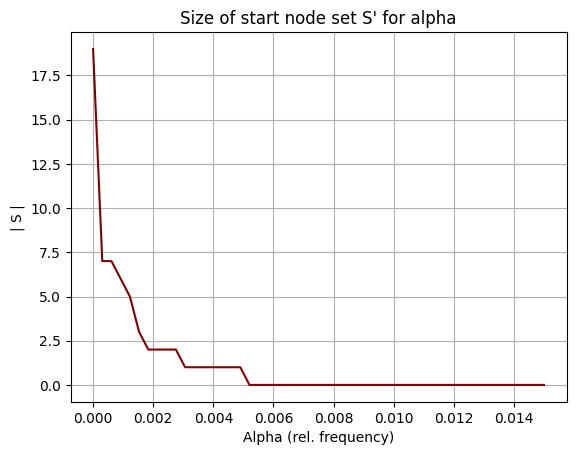

In [17]:
# get the number of shortest paths for each start node in the subgraph

x = []
y = []
for alpha in np.linspace(0.015, 0, 50):
    SG = SubgraphGameOfDrones(GT.G, 
                          target_node=518, k_hops=6, 
                          node_importance_dict=rel_node_imp, 
                          jammer_nodes=jammer_nodes, 
                          alpha_thresh=alpha)
    SG.create_subgraph()
    SG.select_viable_start_nodes()
    x.append(alpha)
    y.append(len(SG.start_nodes))
plt.plot(x,y, color='maroon')
plt.xlabel('Alpha (rel. frequency)')
plt.ylabel(f"| S |")
plt.title("Size of start node set S' for alpha")
plt.grid()

## Value matrix

With the established set of start nodes and the set of jammer nodes, we can now calculate the value matrix for each route against all possible jammer locations.

From the total set of generated routes it shows that the maximum distance is 760 mtr. To err on the side of caution, we assume that the maximum length of a route may add up to 1000 mtrs, so with 240 mtrs margin from the calculated set.

For lexicographic ordering, we need to find the proper $\gamma$ which will allow sufficient resolution between the probability steps to also account for the distance. In the paper, we included eq. 11 to calculate the value of $\gamma$ for the desired resolution of probability and the expected maximum path length (here: 1000 mtrs) as follows:

\begin{equation} 
    \gamma_{0.01} > \frac{\Delta L(p)}{\delta R(P)} = \frac{6}{0.01} = 600
\end{equation}

which gives us:
\begin{equation} 
    \gamma_{0.01} > \frac{\Delta L(p)}{\delta R(P)} = \frac{1000}{0.01} = 100.000
\end{equation}


In [18]:
alpha = 0.002        #for which we know we'll get 10 start nodes at the edges of the subgraph
gamma = 1000 / 0.01  # with max length = 1000 and prob resolution = 0.01
battery = 1000       # max distance a drone flies with single battery charge
k = 10

SG = SubgraphGameOfDrones(GT.G, 
                          target_node=518, k_hops=6, 
                          node_importance_dict=rel_node_imp, 
                          jammer_nodes=jammer_nodes, 
                          alpha_thresh=alpha)

# find the all nodes at max 6 hops from the target
SG.create_subgraph()
SG.select_viable_start_nodes()

print(f"Start nodes for alpha={alpha} are: {SG.start_nodes}")

# use the set of 10 jammer nodes to generate 5 routes per node.
SG.generate_k_shortest_routes(k)

# generate the threat model, based on the reduced jammer node set J' but keep the original probs:
TM = threat_model(SG.subgraph, jammer_nodes, probs)

SG.compute_route_value_matrix(TM)
SG.compute_normalised_scalar_payoff_matrix(gamma=gamma, battery_limit=battery)

Start nodes for alpha=0.002 are: [76, 404]
Threat | Model created, available nodes=[516 608 515 551 607 154 179 319 320 409], probabilities=[0.4, 0.2, 0.05]


NodeNotFound: Source 516 is not in G

## Risk probability distribution

With the attribuut 'route_value_matrix' is it possible to plot the risk probability distribution for the class SubgraphGameOfDrones. The following code counts the risk levels across all route-node pairs and plots these as a scatter plot. Important to see that many routes seem high in risk (lower right hand in the graph) but we still have many routes which have low (2900 with p=0, 2500 with p=2500+ etc in the upper left hand corner.)

In [ ]:
risks = [pair['risk'] for pair in SG.route_value_matrix]
risks_counter = Counter(risks)

for risk in risks_counter:
   plt.scatter(risk, risks_counter[risk], marker='^', color='maroon')
plt.grid()
plt.xlabel('Route risk probability')
plt.ylabel('Count')

nr_routes = (len(SG.routes)-1)*len(SG.routes[SG.start_nodes[0]])
plt.title(f'Counter for route risk over \n m={nr_routes} routes and n={len(SG.jammer_nodes)} jammer nodes')
plt.tight_layout()

## Dominant routes

Even the subgraph still has many routes as we selected the 10 most likely start nodes for which we generated the 10 (k=10) 'k_shortest_routes' to the target. With the set of 100 routes and the 10 most likely jammer nodes, we have 1000 route-node pairs. 

The next step would be to analyse all possible routes for dominance over any of the other ones. This analysis is based on a step by step iteration where for each iteration, all routes and their route-node pairs are compared to the rest of the set of routes. We only consider 'strict domination' before eliminating a dominated route from the set.

The removal of dominated routes may change the domination relationship within the set, so we'll repeat the interative process until no dominated routes are found anymore.

In [ ]:
from collections import defaultdict


def iterative_dominance_elimination(payoff_matrix):
    current_matrix = payoff_matrix.copy()
    route_indices = list(range(current_matrix.shape[0]))  # tracks route indices after pruning

    all_domination_records = []  # list of tuples: (dominator_idx_in_full, dominated_idx_in_full)

    while True:
        nr_routes, nr_nodes = current_matrix.shape
        dom_matrix = np.zeros((nr_routes, nr_routes), dtype=int)

        # Compute domination matrix for current payoff matrix
        for i in range(nr_routes):
            for j in range(nr_routes):
                if i != j and np.all(current_matrix[i] > current_matrix[j]):
                    dom_matrix[i, j] = 1

        dominated_local = np.where(np.any(dom_matrix == 1, axis=0))[0]

        if len(dominated_local) == 0:
            break  # no more dominated routes

        # Map local indices to full matrix indices
        dominated_full = [route_indices[idx] for idx in dominated_local]
        for i_local in range(dom_matrix.shape[0]):
            for j_local in dominated_local:
                if dom_matrix[i_local, j_local] == 1:
                    all_domination_records.append((route_indices[i_local], route_indices[j_local]))

        # Remove dominated strategies
        keep_mask = np.ones(nr_routes, dtype=bool)
        keep_mask[dominated_local] = False
        current_matrix = current_matrix[keep_mask, :]
        route_indices = [r for i, r in enumerate(route_indices) if keep_mask[i]]

    return route_indices, all_domination_records


def group_dominations(domination_records):
    grouped = defaultdict(list)
    for dom, sub in domination_records:
        grouped[dom].append(sub)
    return grouped


def analyze_and_report_dominance(payoff_matrix):
    survivors, domination_log = iterative_dominance_elimination(payoff_matrix)
    table = group_dominations(domination_log)
    return survivors, domination_log


drone_action_space, domination_log = analyze_and_report_dominance(SG.normalised_scalar_payoff_matrix)
print(drone_action_space)

In [ ]:
# now  generate the data for the domination table
def group_dominations_from_survivors(domination_log, survivors):
    from collections import defaultdict
    survivors_set = set(survivors)
    table = defaultdict(list)
    for dom, sub in domination_log:
        if dom in survivors_set:
            table[dom].append(sub)
    return table



# use filtered_table to generate the domination table in the paper.
filtered_table = group_dominations_from_survivors(domination_log, drone_action_space)

# Payoff Matrix

In previous sections we've calculated the action space for the drone ('drone_action_space'), the reduced set of routes after dominated routes have been removed. In addition, we also have the set of jammer nodes ('jammer_nodes').

We'll create a new class which gets both sets and generates the actual payoff matrix, which we will use for further analysis.

In [ ]:
from scipy.optimize import linprog


class payoff_matrix():

    def __init__(self, drone_actions, jammer_actions, value_matrix):
        """
        Defines the class for the payoff matrix, includes methods to analyse
        the game by looking at equilibria, saddle points, mixed strategies
        etc, where applicable
        """
        self.payoff = pd.DataFrame(value_matrix[drone_actions],
                                   index = drone_actions,
                                   columns = jammer_nodes)
        print(f"Payoff matrix | created with shape {self.payoff.shape}")

    def find_pure_nash_equilibrium(self):
        """
        Finds pure strategy Nash equilibria in a zero-sum game.
        Returns a list of (drone_action, jammer_action) tuples.
        """
        # Find row minima (best for drone when jammer picks each column)
        row_min = self.payoff.min(axis=1)
        # Find column maxima (best for jammer when drone picks each row)
        col_max = self.payoff.max(axis=0)
        
        # Find saddle points (simultaneous row minima and column maxima)
        nash_eq = []
        for drone_action in self.payoff.index:
            for jammer_action in self.payoff.columns:
                value = self.payoff.loc[drone_action, jammer_action]
                if (value == row_min[drone_action] and 
                    value == col_max[jammer_action]):
                    nash_eq.append((drone_action, jammer_action))
        
        return nash_eq
    
    def solve_mixed_strategies(self):
        """
        Robust implementation of mixed strategy solver for zero-sum games
        Returns:
        - drone_strat: Optimal strategy for drone player
        - jammer_strat: Optimal strategy for jammer player
        - game_value: Value of the game
        """
        A = self.payoff.values
        m, n = A.shape  # m drone actions, n jammer actions
        
        # Shift payoffs to be positive (doesn't affect optimal strategies)
        A_shifted = A - np.min(A) + 1
        
        try:
            # ===== Solve for drone's strategy (maximin) =====
            # Maximize v subject to A.T @ p >= v
            c = np.zeros(m + 1)
            c[-1] = -1  # Minimize -v (equivalent to maximizing v)
            
            # Constraints: A_shifted.T @ p >= v
            # Reformulated as: -A_shifted.T @ p + v <= 0
            A_ub = np.hstack([-A_shifted.T, np.ones((n, 1))])
            b_ub = np.zeros(n)
            
            # Probability sum constraint: sum(p) = 1
            A_eq = np.zeros((1, m + 1))
            A_eq[0, :m] = 1
            b_eq = np.array([1])
            
            bounds = [(0, None) for _ in range(m)] + [(None, None)]
            
            res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                         A_eq=A_eq, b_eq=b_eq,
                         bounds=bounds,
                         method='highs')
            
            if not res.success:
                raise ValueError("Drone strategy optimization failed")
                
            drone_probs = res.x[:m]
            game_value_shifted = res.x[-1]
            
            # ===== Solve for jammer's strategy (minimax) =====
            # Minimize v subject to A @ q <= v
            c = np.zeros(n + 1)
            c[-1] = 1  # Minimize v
            
            # Constraints: A_shifted @ q <= v
            A_ub = np.hstack([A_shifted, -np.ones((m, 1))])
            b_ub = np.zeros(m)
            
            # Probability sum constraint: sum(q) = 1
            A_eq = np.zeros((1, n + 1))
            A_eq[0, :n] = 1
            b_eq = np.array([1])
            
            res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                         A_eq=A_eq, b_eq=b_eq,
                         bounds=bounds[:n+1],
                         method='highs')
            
            if not res.success:
                raise ValueError("Jammer strategy optimization failed")
                
            jammer_probs = res.x[:n]
            
            # ===== Convert back to original payoff scale =====
            game_value = game_value_shifted + np.min(A) - 1
            
            # ===== Create probability distributions =====
            # Filter out near-zero probabilities
            drone_probs = np.where(drone_probs < 1e-6, 0, drone_probs)
            jammer_probs = np.where(jammer_probs < 1e-6, 0, jammer_probs)
            
            # Normalize
            drone_probs = drone_probs / np.sum(drone_probs)
            jammer_probs = jammer_probs / np.sum(jammer_probs)
            
            drone_strat = pd.Series(drone_probs, index=self.payoff.index, name="Drone")
            jammer_strat = pd.Series(jammer_probs, index=self.payoff.columns, name="Jammer")
            
            return drone_strat, jammer_strat, game_value
            
        except Exception as e:
            print(f"Optimization error: {str(e)}")
            print("Falling back to iterative method...")
            
            # Fallback to fictitious play approximation
            return self.approximate_mixed_strategies()
    
    def approximate_mixed_strategies(self, iterations=1000):
        """Fictitious play approximation when LP fails"""
        A = self.payoff.values
        m, n = A.shape
        
        # Initialize strategies uniformly
        drone_strat = np.ones(m)/m
        jammer_strat = np.ones(n)/n
        
        # Fictitious play iteration
        for _ in range(iterations):
            # Jammer best response to current drone strategy
            jammer_br = np.zeros(n)
            jammer_br[np.argmin(A.T @ drone_strat)] = 1
            
            # Drone best response to current jammer strategy
            drone_br = np.zeros(m)
            drone_br[np.argmax(A @ jammer_strat)] = 1
            
            # Update strategies
            drone_strat = (drone_strat * _ + drone_br) / (_ + 1)
            jammer_strat = (jammer_strat * _ + jammer_br) / (_ + 1)
        
        # Calculate game value
        game_value = drone_strat @ A @ jammer_strat
        
        # Create pandas Series
        drone_series = pd.Series(drone_strat, index=self.payoff.index, name="Drone")
        jammer_series = pd.Series(jammer_strat, index=self.payoff.columns, name="Jammer")
        
        return drone_series, jammer_series, game_value

    
    def analyze_game(self):
        """Convenience method to run both analyses"""
        print("=== Pure Strategy Nash Equilibrium ===")
        nash_eq = self.find_pure_nash_equilibrium()
        if nash_eq:
            for eq in nash_eq:
                print(f"Drone action: {eq[0]}, Jammer action: {eq[1]}")
                print(f"Payoff value: {self.payoff.loc[eq[0], eq[1]]:.4f}")
        else:
            print("No pure strategy Nash equilibrium found")
        
        print("\n=== Optimal Mixed Strategies ===")
        drone_strat, jammer_strat, value = self.solve_mixed_strategies()
        print(f"Game value: {value:.4f}")
        
        print("\nDrone optimal strategy:")
        print(drone_strat[drone_strat > 1e-6].round(4))  # Show non-zero probabilities
        
        print("\nJammer optimal strategy:")
        print(jammer_strat[jammer_strat > 1e-6].round(4))  # Show non-zero probabilities
                                    

PM = payoff_matrix(drone_action_space, jammer_nodes, SG.normalised_scalar_payoff_matrix)
PM.payoff.round(2)
PM.analyze_game()

In [ ]:
#Plot a specified route (list of node IDs) on the shared ax

def plot_graph_routes_jammer_nodes(graph, routes, jammer_nodes, target=518):

    fig, ax = ox.plot_graph(graph, figsize=(12, 10), node_size=10, show=False, close=False)
    
    for route, color, label in zip(routes, ['orange', 'yellow'], ['Route81', 'Route90']):
        # Extract coordinates
        x = [graph.nodes[node]['x'] for node in route]
        y = [graph.nodes[node]['y'] for node in route]
        
        # Plot the route on the existing axis
        ax.plot(x, y, color=color, linewidth=4, zorder=4)
        ax.scatter(x, y, color=color, s=50, zorder=4, label=label)
        
        # Optionally highlight start and end
        ax.scatter(x[0], y[0], color='green', s=30, zorder=5, label='start nodes')  # start node
        ax.text(x[0]-0.0005, y[0]+0.0002, s=f"V={route[0]}", color=color)
        ax.scatter(x[-1], y[-1], color='red', s=30, zorder=5)  # end node

    # plot both jammer nodes in maroon
    for node in jammer_nodes:
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color='maroon', s=50, zorder=5, label='jammer node')
        ax.text(graph.nodes[node]['x']-0.0005, graph.nodes[node]['y']-0.0003, s=f"J={node}", color='white')

    # now show target as larger bright red circle behind the routes and jammer nodes
    ax.scatter(graph.nodes[target]['x'], graph.nodes[target]['y'], color='red', s=250, zorder=3, label='target @ node518')
    ax.text(graph.nodes[target]['x']-0.0005, graph.nodes[target]['y']+0.0003, s=f"T={target}", color='red')

    plt.legend()
    plt.tight_layout()
    plt.savefig('GoD_endgame.png')


Route81 = [319, 444, 443, 442, 518]
Route90 = [504, 539, 409, 553, 610, 517, 518]
plot_graph_routes_jammer_nodes(SG.subgraph, [Route81, Route90], [518, 517])

In [ ]:
PM.payoff

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the domain
x = np.linspace(0, 1, 500)

# Correct payoff values from user-provided matrix
A_81_518 = -0.721996
A_81_517 = -0.541402
A_90_518 = -0.721853
A_90_517 = -0.838336
A_30_518 = -0.748609
A_30_517 = -0.830554

# Expected utilities as functions of jammer strategy
u_81 = A_81_518 * x + A_81_517 * (1 - x)
u_90 = A_90_518 * x + A_90_517 * (1 - x)
u_30 = A_30_518 * x + A_30_517 * (1 - x)

# Pointwise maximum of the two (value to the drone)
game_value = np.maximum(u_81, u_90)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, u_81, label=r'$u_{81}(x) = -0.18x - 0.54$', color='blue')
plt.plot(x, u_90, label=r'$u_{90}(x) = 0.12x - 0.84$', color='green')
plt.plot(x, u_30, label=r'$u_{30}(x) = 0.08x - 0.83$', color='maroon', linestyle=':')
plt.plot(x, game_value, label='Game Value', color='black', linestyle='--')

# Mark the intersection (saddle point)
intersection_x = (A_90_517 - A_81_517) / ((A_81_518 - A_81_517) + (A_90_517 - A_90_518))
intersection_y = A_81_518 * intersection_x + A_81_517 * (1 - intersection_x)
plt.plot(intersection_x, intersection_y, 'ro', label='Saddle Point')
print(intersection_x, intersection_y)

plt.title("Expected Drone Payoff vs. Jammer Mixed Strategy")
plt.xlabel("Probability of jammer choosing node 518")
plt.ylabel("Expected payoff to drone")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
image_path = "saddle_point_plot_Tilburg map.png"
plt.savefig(image_path, dpi=300)
plt.show()

image_path


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the domain
x = np.linspace(0, 1, 500)

# Correct payoff values from user-provided matrix
A_518_81 = -0.721996
A_518_90 = -0.721853
A_517_81 = -0.541402
A_517_90 = -0.838336

# Expected utilities as functions of jammer strategy
u_518 = A_518_81 * x + (1-x) * A_518_90
u_517 = A_517_81 * x + (1-x) * A_517_90


# Pointwise maximum of the two (value to the drone)
game_value = np.maximum(u_518, u_517)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, u_517, label=r'$u_{517}(x) = -0.297x - 0.84$', color='blue')
plt.plot(x, u_518, label=r'$u_{518}(x) = 0.001x - 0.72$', color='green')
plt.plot(x, game_value, label='Game Value', color='black', linestyle='--')

# Mark the intersection (saddle point)
intersection_x = .3902
intersection_y = A_518_81 * intersection_x + (1-intersection_x)*A_518_90
plt.plot(intersection_x, intersection_y, 'ro', label='Saddle Point')
print(intersection_x, intersection_y)

plt.title("Expected Jammer Payoff vs. Drone Mixed Strategy")
plt.xlabel("Probability of drone choosing route 81")
plt.ylabel("Expected payoff to jammer")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
image_path = "saddle_point_plot_Tilburg map_drone.png"
plt.savefig(image_path, dpi=300)
plt.show()

image_path
